Clustering
===
Bothound project. 

In [82]:
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist,pdist
from scipy.signal import argrelextrema
%matplotlib inline
from pylab import *
from numpy import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt

db_host = '127.0.0.1'
db_name = 'bothound'
db_user = 'root'
db_password = '7k32uW+C!JMFXTRT'

features = [
            "request_interval", #1
            #"ua_change_rate",#2
            "html2image_ratio",#3
            "variance_request_interval",#4
            #"payload_average",#5
            #"error_rate",#6
            #"request_depth",#7
            #"request_depth_std",#8
            "session_length",#9
            #"percentage_cons_requests",#10
            ]
columns = []
for f in features:
    columns.append((f, 'float'))


# Read From Database

In [83]:
import MySQLdb
id_incident = 18

db = MySQLdb.connect(host = db_host, user = db_user, passwd = db_password, db = db_name)
cur = db.cursor(MySQLdb.cursors.DictCursor)
cur.execute("select * from sessions WHERE id_incident = {0}".format(id_incident))
sessions = [dict(elem) for elem in cur.fetchall()]
db.close()
values = []
for s in sessions:
    row = []
    for f in features:
        row.append(s[f])
    values.append(row)
X = np.array(values)
print X.shape

(191231, 4)


# PCA

In [69]:
# perform PCA dimensionality reduction
pca = sklearn.decomposition.RandomizedPCA(n_components=3).fit(X)
X = pca.transform(X)

#totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
#print "totl ss", totss

# K-Means

## 333

[191231]
[185100, 6131]
[131137, 6001, 54093]
[120425, 4278, 52765, 13763]
[116930, 52765, 3319, 3660, 14557]
[111897, 2747, 52765, 2845, 7386, 13591]
[109158, 1828, 52765, 8424, 2640, 13276, 3140]
[52765, 108570, 1811, 7139, 2631, 3042, 13129, 2144]
[107180, 1426, 52765, 3044, 7270, 2526, 13079, 2147, 1794]
[52765, 13153, 1386, 5077, 1622, 102797, 2537, 2145, 2519, 7230]
Num clusters: 4
[120425, 4278, 52765, 13763]


<Container object of 4 artists>

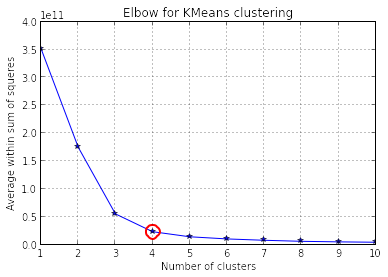

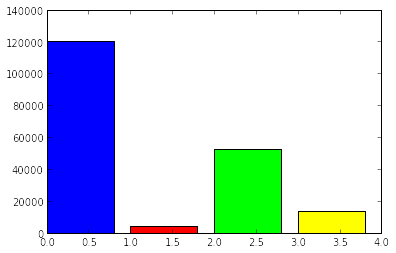

In [84]:
import sklearn
from sklearn.cluster import KMeans
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm

max_number_of_clusters = 10
color_set = [
[0, 0, 255],      #Blue
[255, 0, 0],      #Red
[0, 255, 0],      #Green
[255, 255, 0],    #Yellow
[255, 0, 255],    #Magenta
[255, 128, 128],  #Pink
[128, 128, 128],  #Gray
[128, 0, 0],      #Brown
[255, 128, 0],    #Orange
]

def get_colors(N=5):
    result = []
    for x in range(N):
        s = color_set[x % len(color_set)]
        result.append([s[0]/255.0,s[1]/255.0,s[2]/255.0,1])
    return result
palette = get_colors(max_number_of_clusters+1)


def get_best_clustering_model(X, max_number_of_clusters):
    cost = []
    KK = range(1,max_number_of_clusters+1)
    kms = []
    # calculate all the clustering and cost
    for no_of_clusters in KK:
        km = KMeans(n_clusters=no_of_clusters, precompute_distances = True, max_iter = 500, n_init = 30)
        km.fit(X)
        kms.append(km)
        
        sizes = [0]*no_of_clusters
        for i in km.predict(X): 
            sizes[i] = sizes[i]+1
        print sizes
        
        cost.append(km.inertia_)
    
    derivative1 = [cost[i+1]-cost[i] for i in range(len(cost)-1)]
    derivative2 = [derivative1[i+1]-derivative1[i] for i in range(len(derivative1)-1)]
    max2 = argrelextrema(np.argsort(derivative2), np.less) 
    num_clusters = 4 
    if(len(max2[0]) > 0):
        num_clusters = max2[0][0] + 3
    else:
        derivative3 = [derivative2[i+1]-derivative2[i] for i in range(len(derivative2)-1)]
        max3 = argrelextrema(np.argsort(derivative3), np.greater) 
        if(len(max3[0]) > 0):
            num_clusters = max3[0][0] + 4 
    return kms[num_clusters-1], cost

model,cost = get_best_clustering_model(X, max_number_of_clusters)

labels = model.predict(X)

num_clusters = model.n_clusters
print "Num clusters:", num_clusters

KK = range(1,max_number_of_clusters+1)

# elbow curve
kIdx = num_clusters      
clr = cm.spectral( np.linspace(0,1,10) ).tolist()
mrk = 'os^p<dvh8>+x.'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, cost, 'b*-')
ax.plot(num_clusters, cost[num_clusters-1], marker='o', markersize=14, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
#ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
#plt.ylabel('Percentage of variance explained (%)')
plt.ylabel('Average within sum of squeres')
plt.title('Elbow for KMeans clustering')


#cluster histogramm
sizes = [0]*model.n_clusters
for i in model.predict(X): 
    sizes[i] = sizes[i]+1
print sizes
index_max = sizes.index(max(sizes))

cluster_sizes = float(sizes[index_max])/ X.shape[0] * 100

#print cluster_sizes
left = [] 
for i in range(len(sizes)):
    left.append(i)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(left,sizes, color = palette)

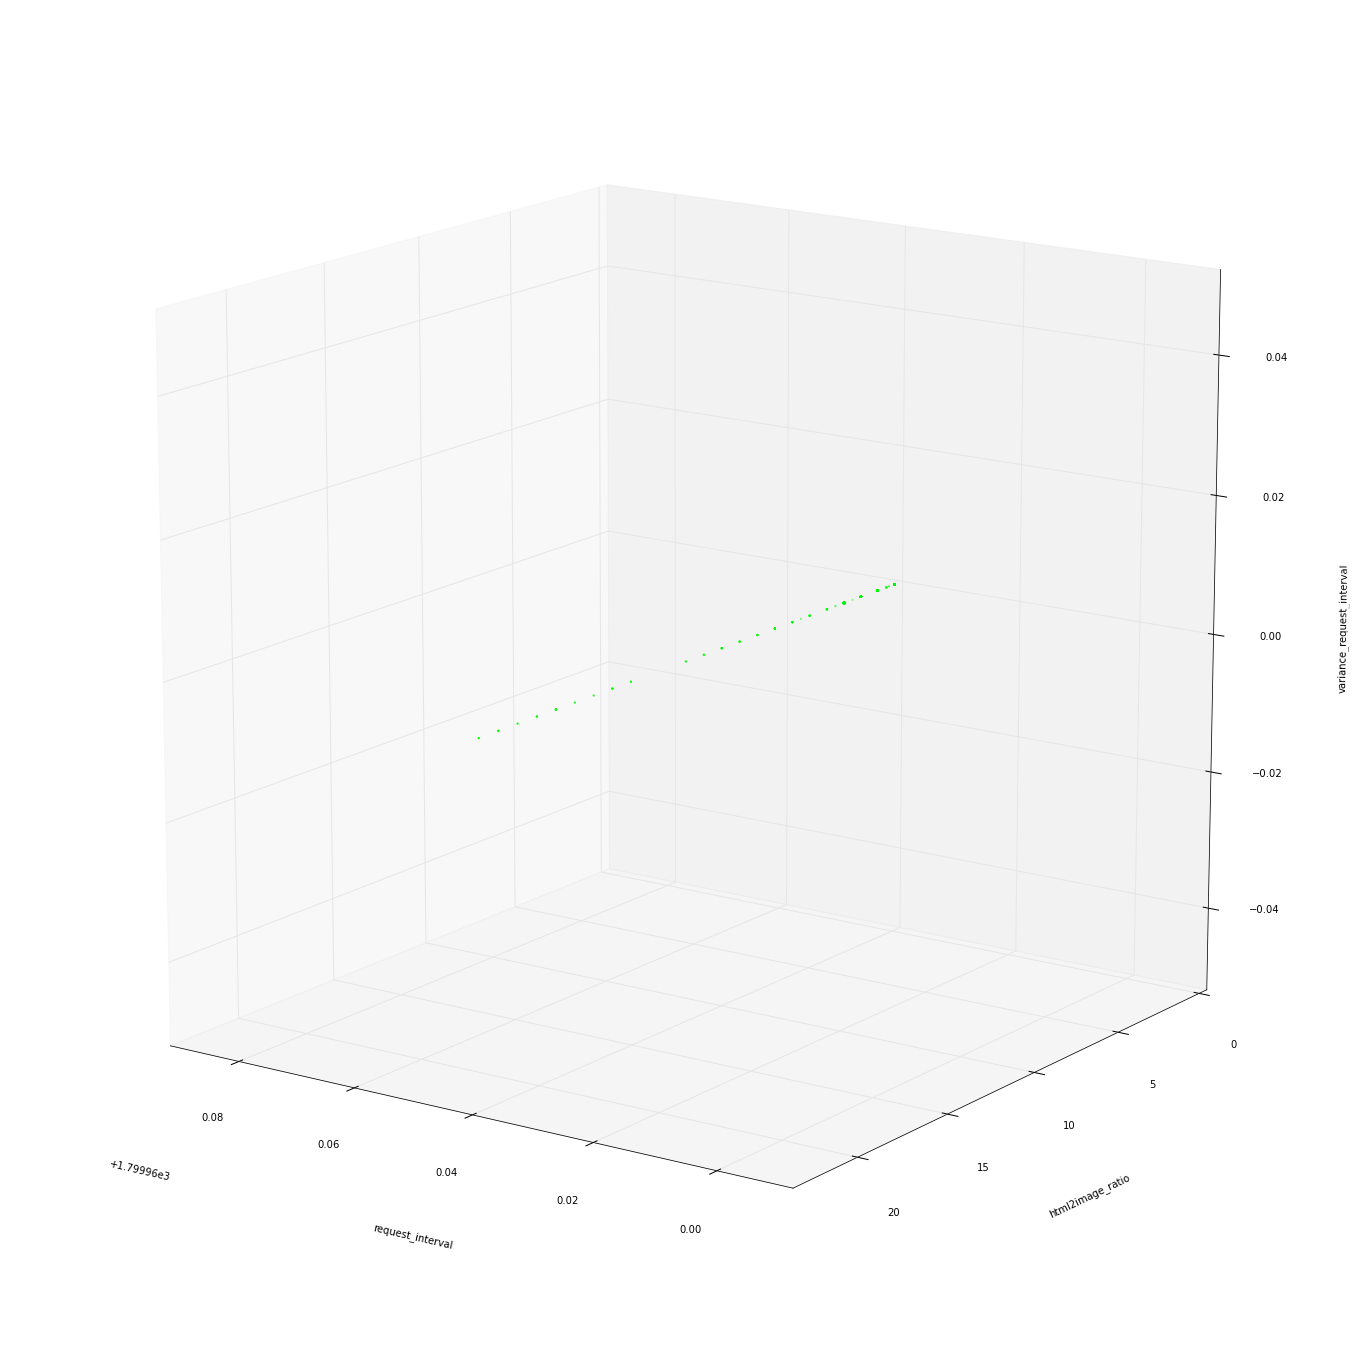

In [87]:
selected = 2

if selected >= 0 :
    X_plot = X[labels == selected,: ]
    labels_plot = labels[labels == selected]
else:
    X_plot = X
    labels_plot = labels
    
colors = []
g = 0
for i in labels_plot:
    colors.append(palette[i])
    
def plot3(indexes):
    fig = figure(figsize=(24,24))
    ax = fig.gca(projection='3d')
    #fig = plt.figure(figsize=(14,14))
    #ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel(features[indexes[0]])
    ax.set_ylabel(features[indexes[1]])
    ax.set_zlabel(features[indexes[2]])
    azim = 125
    elev = 15
    #ax.set_autoscale_on(False)
    #ax.axis([0.9, 1.5, -50, 50, 0, 400000])
    ax.view_init(elev, azim) 

    # plot points in 3D
    class1 = 0.6 * random.standard_normal((200,3))
    x = X_plot[:,indexes[0]]
    y = X_plot[:,indexes[1]]
    z = X_plot[:,indexes[2]]

    ax.scatter(x,y,z, s=5, edgecolors='none', c = colors, marker='o')

plot3([0,1,2])

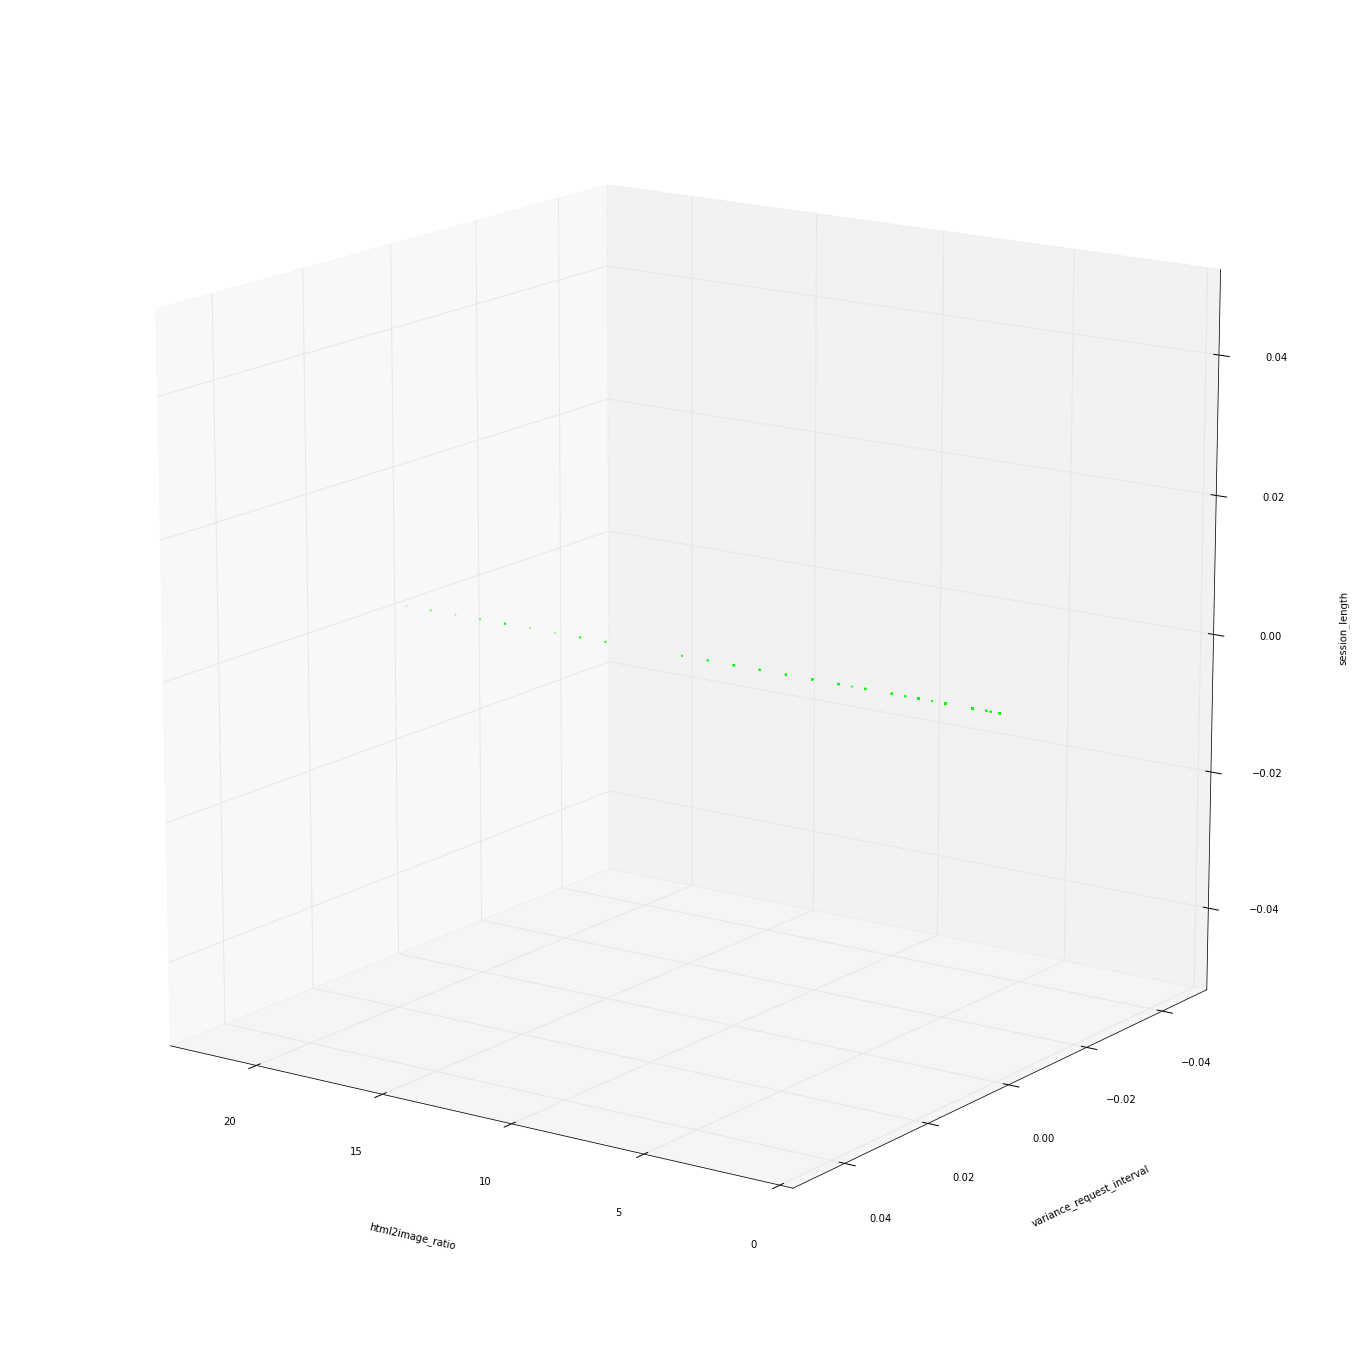

In [88]:
plot3([1,2,3])

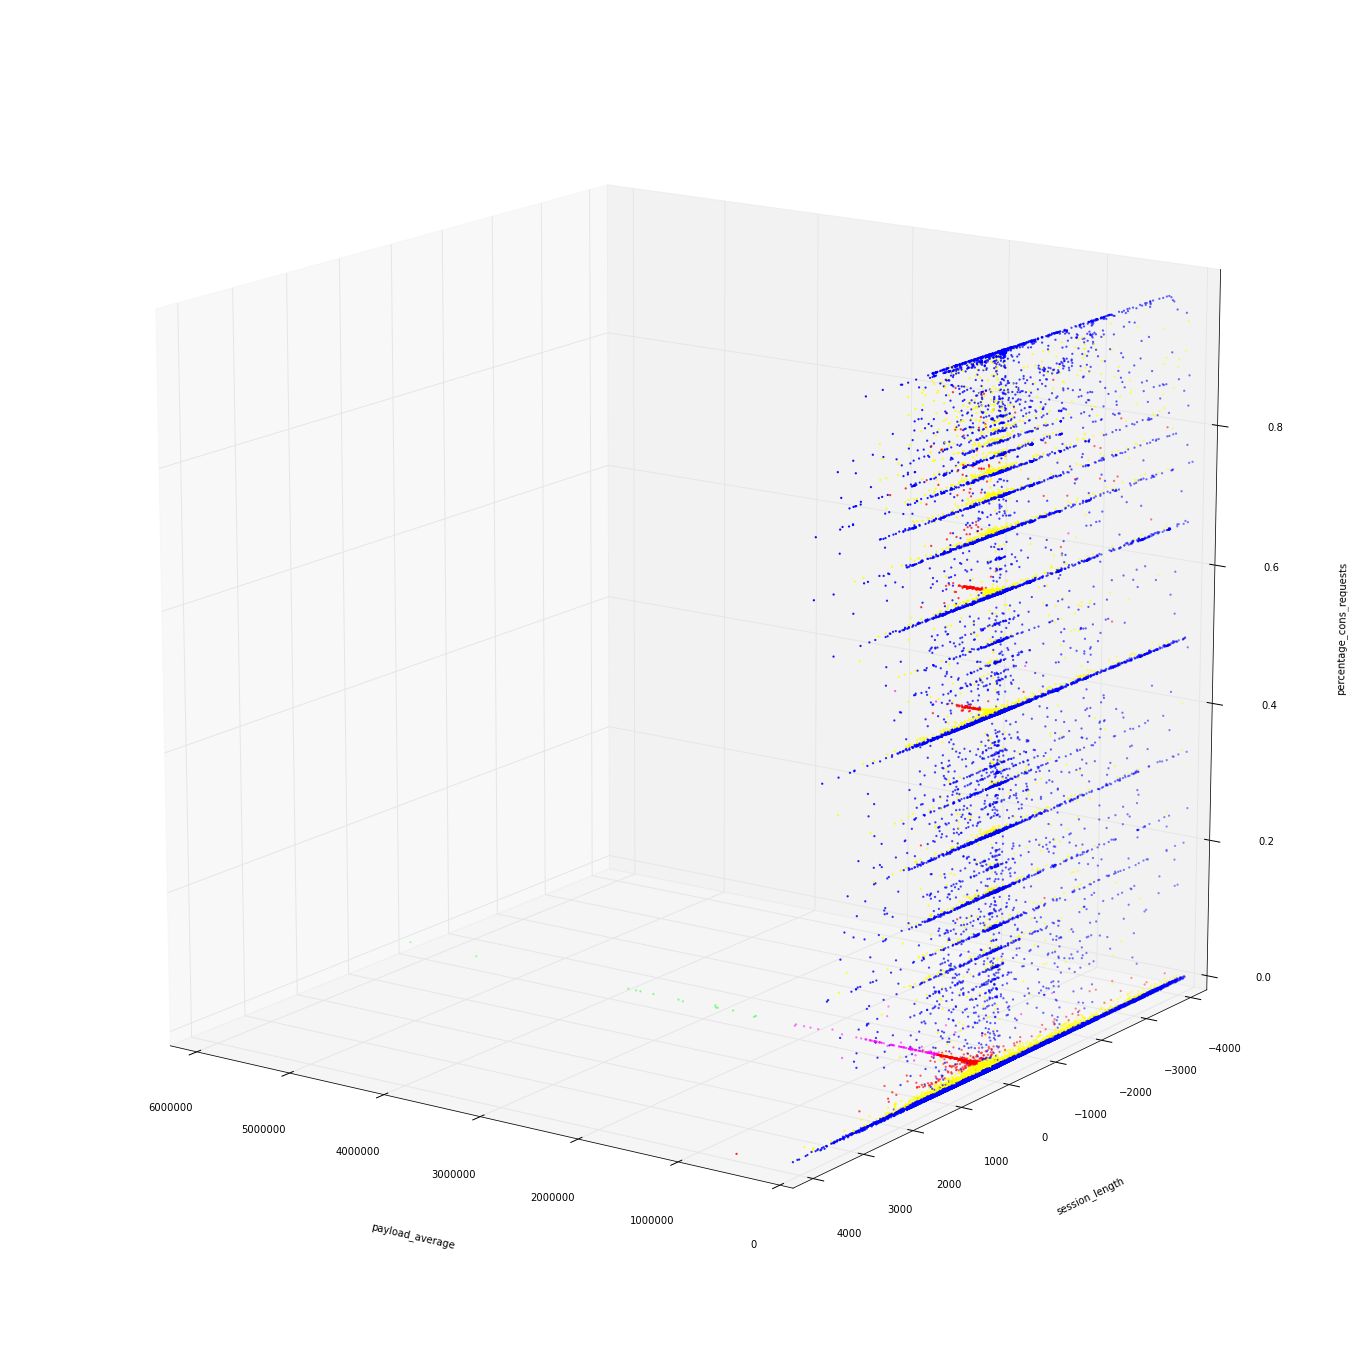

In [5]:
plot3([1,3,4])

# Saving Clusters

In [47]:
db = MySQLdb.connect(host = db_host, user = db_user, passwd = db_password, db = db_name)
cur = db.cursor(MySQLdb.cursors.DictCursor)
for session, label in zip(sessions, labels):
    cur.execute("update sessions set cluster_index={} WHERE id = {}".format(label,session["id"]))
db.commit()
db.close()

# Saving Decision

In [49]:
selected_cluster = 1
db = MySQLdb.connect(host = db_host, user = db_user, passwd = db_password, db = db_name)
cur = db.cursor(MySQLdb.cursors.DictCursor)
cur.execute("update incidents set selected_cluster={} WHERE id = {}".format(selected_cluster,id_incident))
db.commit()
db.close()

OperationalError: (1054, "Unknown column 'selected_cluster' in 'field list'")

In [50]:
db.close()